In [1]:
#Kyle Ruhl [kr548@cornell.edu] EAS 3540 Synoptic Meteorology 1 Final Project
%matplotlib notebook

The objective of this program is to plot/contour stability indicies over the US and see how stability/instability develops and progresses graphically. To achive this, an animation of K-Index, Totals-Totals Index, Surface Pressure, and Surface Temperature will be anomated over a period of days for a convective event. 

In [9]:
#Import python packages 
import numpy as np                
import xarray as xr               

import matplotlib as mpl        
import matplotlib.pyplot as plt    
import matplotlib.animation as manim
import matplotlib.ticker as mticker

import cartopy              
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import display, clear_output, HTML  
from ipywidgets import FloatProgress

import time, datetime    

import imageio #for creating animation
import os

In [3]:
#Using datautils, get GFS reanalysis data for given timeperiod with height, relative humidity, wind, pressure
from commontools import datautils
startdate = '2021-12-07T12:00'
stopdate = '2021-12-12T12:00'
dat = datautils.get_analysis('GFS',startdate,stopdate, ['Z','RelHum', 'T', 'U', 'V','PSL'], time_step = 6)

Reading data from /scratch/eas3421/adm_data/main/.
Writing new data to /scratch/eas3421/2022S/kr548/adm_data/.
Requested 5.25 days, 21 timesteps.
Done.


In [4]:
#Timestamps for event
times = ['2021-12-07T12:00','2021-12-07T18:00','2021-12-08T00:00','2021-12-08T06:00','2021-12-08T12:00',
        '2021-12-08T18:00','2021-12-09T00:00','2021-12-09T06:00','2021-12-09T12:00','2021-12-09T18:00',
        '2021-12-10T00:00','2021-12-10T06:00','2021-12-10T12:00','2021-12-10T18:00','2021-12-11T00:00',
        '2021-12-11T06:00','2021-12-11T12:00','2021-12-11T18:00','2021-12-12T00:00','2021-12-12T06:00',
        '2021-12-12T12:00']

In [7]:
#Define function to get temperature at a pressure level for a given lat/lon
def getT(data,ti,pres): #get temperature from GFS
    temps = data.sel(lev = pres, time = ti)
    return (temps-273.15) #convert from K to C

#Define function to get dew point temp at a pressure level for a given lat/lon using relative humidity
def getTd(data,ti,pres,temp): #get dew point [deg c]
    rh = data.sel(lev=pres, time=ti)
    n =  (np.log(rh/100) + ((17.27*temp)/(273.3+temp)))/17.27
    dew = (273.3*n) / (1-n)
    return dew

lon = dat.lon
lat = dat.lat

<IPython.core.display.Javascript object>


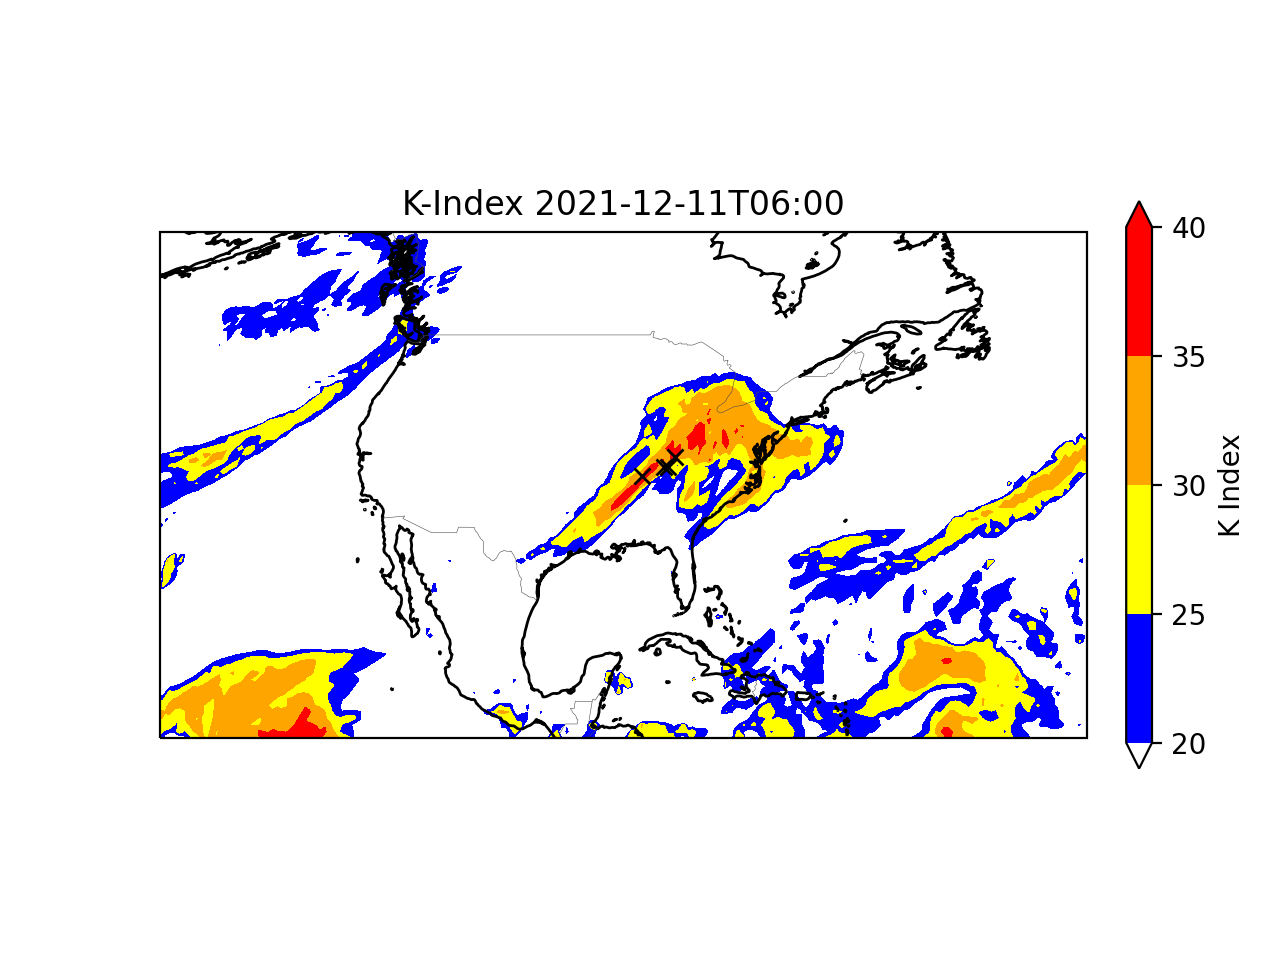

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [29]:
## K-INDEX

#Define function to solve K-Index formula at a location
def solve_KIndex(timestamp, tempdat, relhumdat):
    t500 = getT(tempdat,timestamp, 500)
    t700 = getT(tempdat,timestamp, 700)
    t850 = getT(tempdat,timestamp, 850)
    td850 = getTd(relhumdat,timestamp, 850, t850)
    td700 = getTd(relhumdat,timestamp, 700, t700)
    return (t850-t500)+td850-(t700-td700)

#Define function to plot the K-Index
def plot_KIndex(kindex, time,row,col,pos,supress):
    kindex = kindex.squeeze()
    
    #Define Color Bar for K-Index based on severity values---
    colors = ["blue", "yellow", "orange", "red"]
    cmap = mpl.colors.ListedColormap(colors)
    cmap.set_under("white") #no convection potential set white
    cmap.set_over("red") 
    bounds = [20, 25, 30, 35, 40] #severity index groupings for kindex bounds
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    
    proj = ccrs.EckertIV(central_longitude=0, false_easting=None, false_northing=None, globe=None) #create projection
    ax1 = plt.subplot(row,col,pos,projection = proj) 
    h1 = ax1.contourf(lon,lat,kindex,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=bounds,extend='both') #plot data
    ax1.coastlines() #add coastlines
    ax1.add_feature(cf.BORDERS.with_scale('50m'),edgecolor=[.3,.3,.3],linewidth=0.2) #add borders
    
    if supress == False:
        #Plot black x for tornado starting location at 6Z 12/11/21 (verification figure)
        ax1.plot(-89.26,36.12,'kx',markersize=6,transform=ccrs.PlateCarree()) #plot tornado x
        ax1.plot(-87.0135,36.8594,'kx',markersize=6,transform=ccrs.PlateCarree()) #plot tornado x
        ax1.plot(-86.1383,37.7753,'kx',markersize=6,transform=ccrs.PlateCarree()) #plot tornado x
        ax1.plot(-86.618,36.916,'kx',markersize=6,transform=ccrs.PlateCarree()) #plot tornado x
    
    fig.colorbar(h1,ax=ax1,label='K Index',fraction=0.026, pad=0.04) #add colorbar w/ label
    ax1.set_extent([-45,-135,15,60],crs=ccrs.PlateCarree()) #Alter lat/long to zoom in on USA
    ax1.set_title('K-Index ' + time) #add figure title
    if supress == True:
        ax1.set_title('K-Index') #add figure title
    else:
        ax1.set_title('K-Index '+ time) #add figure title with timestamp
    
timestamp = '2021-12-11T06:00' #timestamp for single frame
fig = plt.figure()
plot_KIndex(solve_KIndex(timestamp, dat.T, dat.RelHum),timestamp,1,1,1,False) #plot single frame @ 6Z 12/11/21

<IPython.core.display.Javascript object>


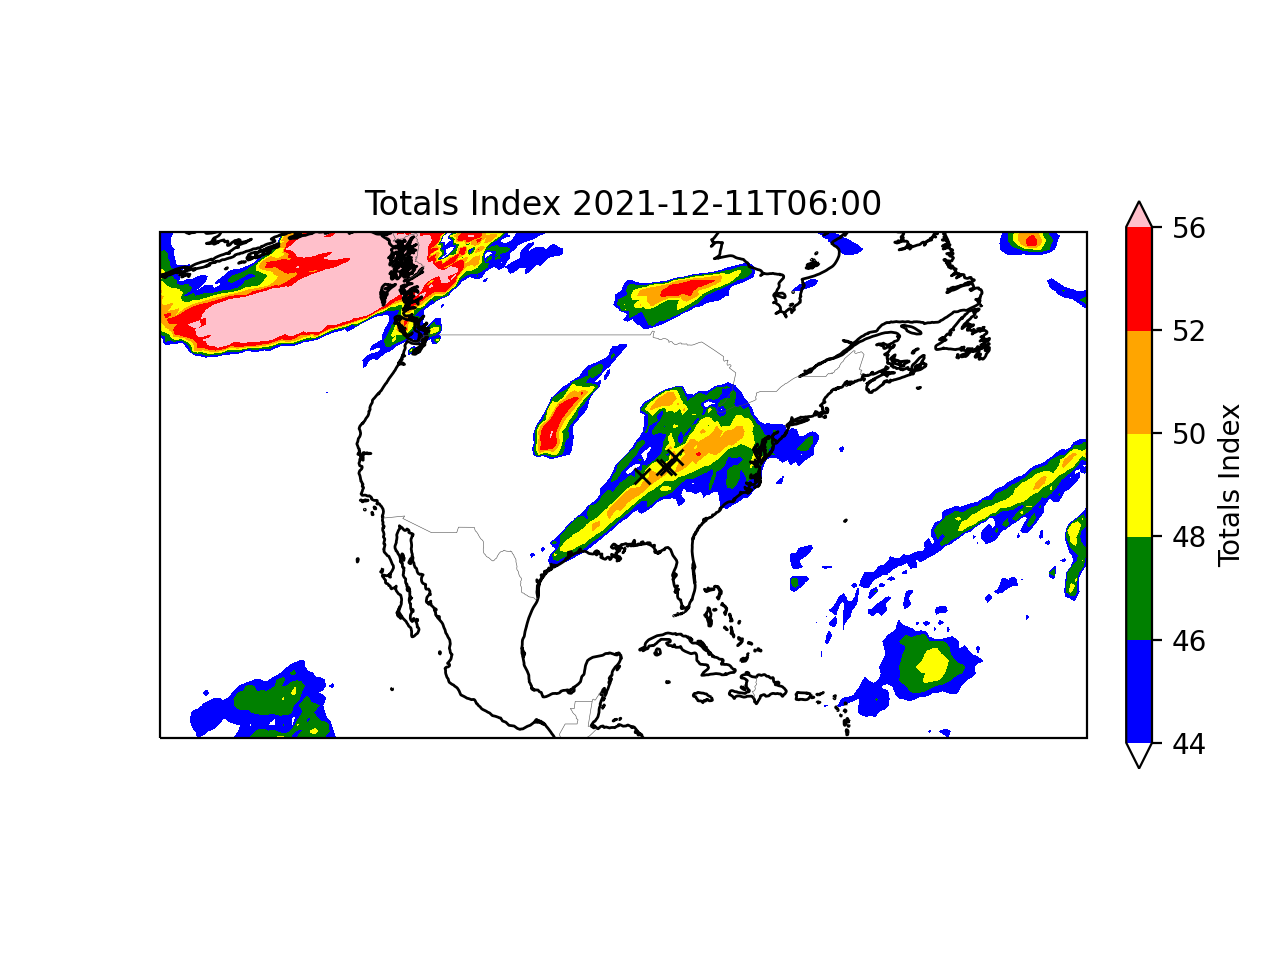

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [28]:
## Totals-Totals Index

#define function to calculate totals index
def solveTotals(timestamp,tempdat,relhumdat):
    t500 = getT(tempdat,timestamp, 500)
    t850 = getT(tempdat,timestamp, 850)
    td850 = getTd(relhumdat,timestamp, 850, t850)
    return t850 + td850 - 2*t500

#define function to plot totals index, contour based on severity of convection potential
def plot_Totals(totals, time, row,col,pos,supress):
    totals = totals.squeeze()
    
    #Define Color Bar bins for Totals-Index ----
    colors2 = ["blue", "green", "yellow", "orange", "red"]
    cmap2 = mpl.colors.ListedColormap(colors2)
    cmap2.set_under("white") #no convection potential set white
    cmap2.set_over("pink")
    bounds2 = [44, 46, 48, 50, 52, 56] #severity index groupings for totals index bounds
    norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N)
    
    proj = ccrs.EckertIV(central_longitude=0, false_easting=None, false_northing=None, globe=None) #create projection  
    ax2 = plt.subplot(row,col,pos,projection = proj) 
    h2 = ax2.contourf(lon,lat,totals,transform=ccrs.PlateCarree(),cmap=cmap2,norm=norm2,levels=bounds2,extend='both') #plot data
    ax2.coastlines() #add coastlines
    ax2.add_feature(cf.BORDERS.with_scale('50m'),edgecolor=[.3,.3,.3],linewidth=0.2) #add borders
    
    if supress == False:
        #Plot black x for tornado starting location at 6Z 12/11/21 (verification figure)
        ax2.plot(-89.26,36.12,'kx',markersize=6,transform=ccrs.PlateCarree()) #plot tornado x
        ax2.plot(-87.0135,36.8594,'kx',markersize=6,transform=ccrs.PlateCarree()) #plot tornado x
        ax2.plot(-86.1383,37.7753,'kx',markersize=6,transform=ccrs.PlateCarree()) #plot tornado x
        ax2.plot(-86.618,36.916,'kx',markersize=6,transform=ccrs.PlateCarree()) #plot tornado x
    
    fig.colorbar(h2, ax=ax2,label='Totals Index',fraction=0.026, pad=0.04) #add colorbar w/ label
    ax2.set_extent([-45,-135,15,60],crs=ccrs.PlateCarree()) #Alter lat/long to zoom in on USA
    if supress == True:
        ax2.set_title('Totals Index') #add figure title
    else:
        ax2.set_title('Totals Index '+ time) #add figure title with timestamp

timestamp = '2021-12-11T06:00' #timestamp for single frame
fig = plt.figure()
plot_Totals(solveTotals(timestamp, dat.T, dat.RelHum),timestamp,1,1,1,False) #plot single frame

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


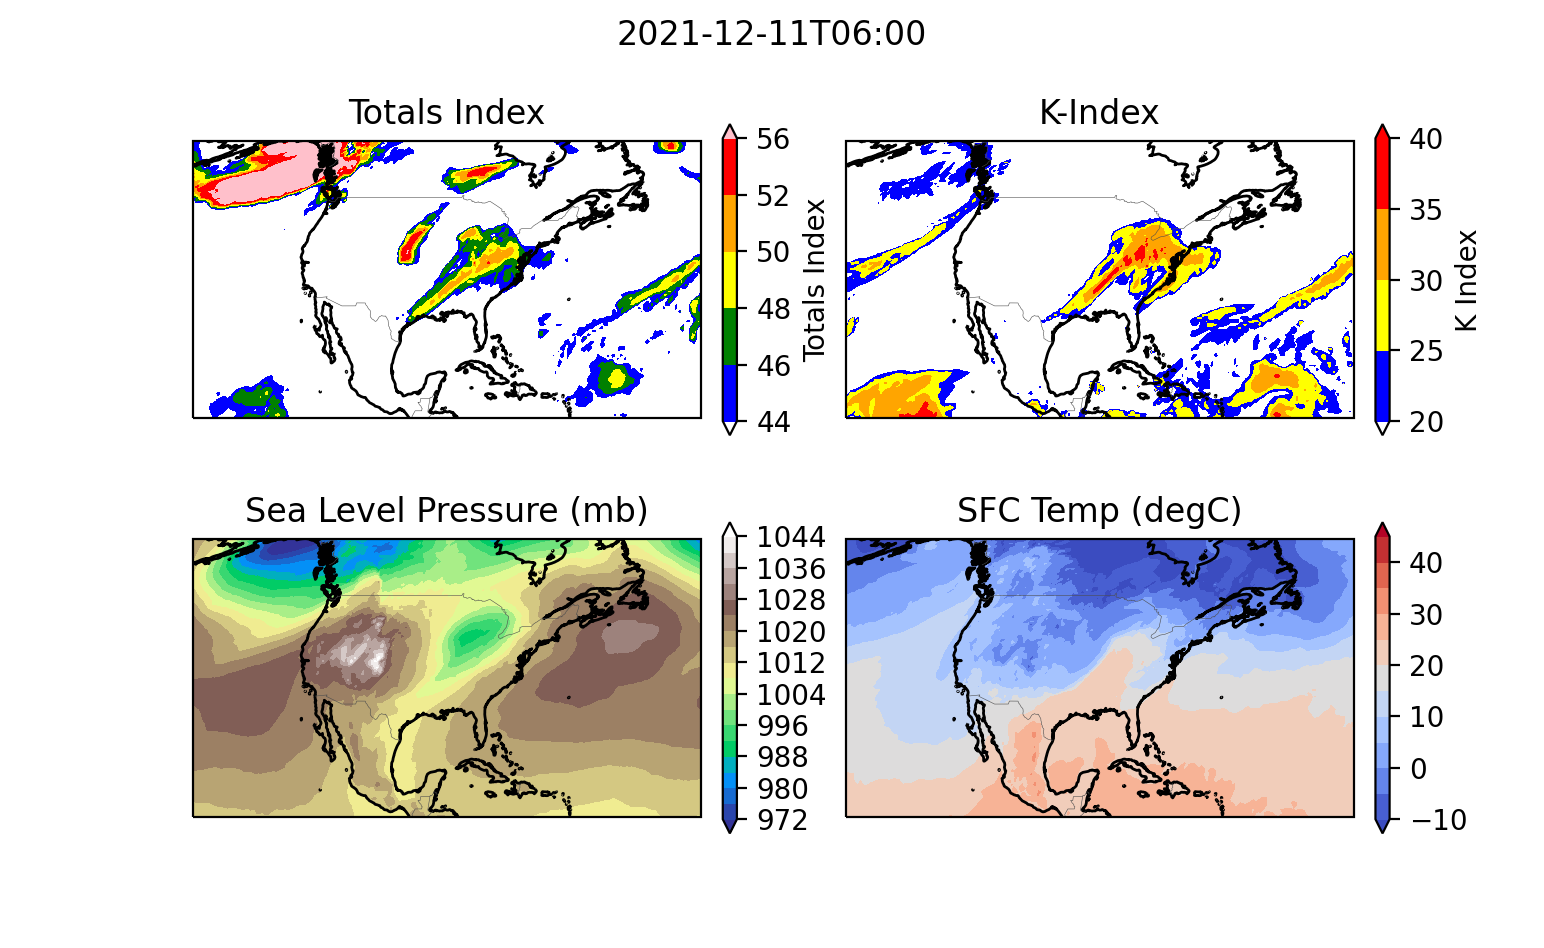

In [30]:
#Plot Quad-plot of Kindex, Totals Index, SLP, SFCT
def plot_both(TTIval,KIval,pres,temp,time):

    fig = plt.figure() #figsize=(18,6)
    plt.suptitle(time) #set master title to be time stamp
   
    plot_Totals(TTIval,time,2,2,1,True) #plot totals index
    plot_KIndex(KIval,time,2,2,2,True) #plot k index
    
    #plot sea level pressure (mb)
    pres = pres.squeeze()
    pres = pres.sel(time = time) / 100.
    clevs = np.arange(972,1048,4)

    proj = ccrs.EckertIV(central_longitude=0, false_easting=None, false_northing=None, globe=None) #create projection
    ax3 = plt.subplot(2,2,3,projection = proj) 
    h3 = ax3.contourf(lon,lat,pres,transform=ccrs.PlateCarree(),cmap=plt.cm.terrain, extend='both', levels=clevs) #plot data
    ax3.coastlines() #add coastlines
    ax3.add_feature(cf.BORDERS.with_scale('50m'),edgecolor=[.3,.3,.3],linewidth=0.2) #add borders
    
    fig.colorbar(h3,fraction=0.026, pad=0.04) #add colorbar w/ label
    ax3.set_extent([-45,-135,15,60],crs=ccrs.PlateCarree()) #Alter lat/long to zoom in on USA
    ax3.set_title('Sea Level Pressure (mb)') #add figure title
    
    #plot surface temperature (deg celcius)
    temp = temp.squeeze()
    temp = temp-273.15 #k to degC
    temp = temp.sel(time = time, lev=1000)
    clevs2 = np.arange(-10,50,5)

    proj = ccrs.EckertIV(central_longitude=0, false_easting=None, false_northing=None, globe=None) #create projection
    ax4 = plt.subplot(2,2,4,projection = proj) 
    h4 = ax4.contourf(lon,lat,temp,transform=ccrs.PlateCarree(),cmap='coolwarm', extend='both', levels=clevs2) #plot data
    ax4.coastlines() #add coastlines
    ax4.add_feature(cf.BORDERS.with_scale('50m'),edgecolor=[.3,.3,.3],linewidth=0.2) #add borders
    
    fig.colorbar(h4,fraction=0.026, pad=0.04) #add colorbar w/ label
    ax4.set_extent([-45,-135,15,60],crs=ccrs.PlateCarree()) #Alter lat/long to zoom in on USA
    ax4.set_title('SFC Temp (degC)') #add figure title


timestamp = '2021-12-11T06:00' #timestamp for single frame
plot_both(solveTotals(timestamp, dat.T, dat.RelHum), solve_KIndex(timestamp, dat.T, dat.RelHum),dat.PSL,dat.T,timestamp)


/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


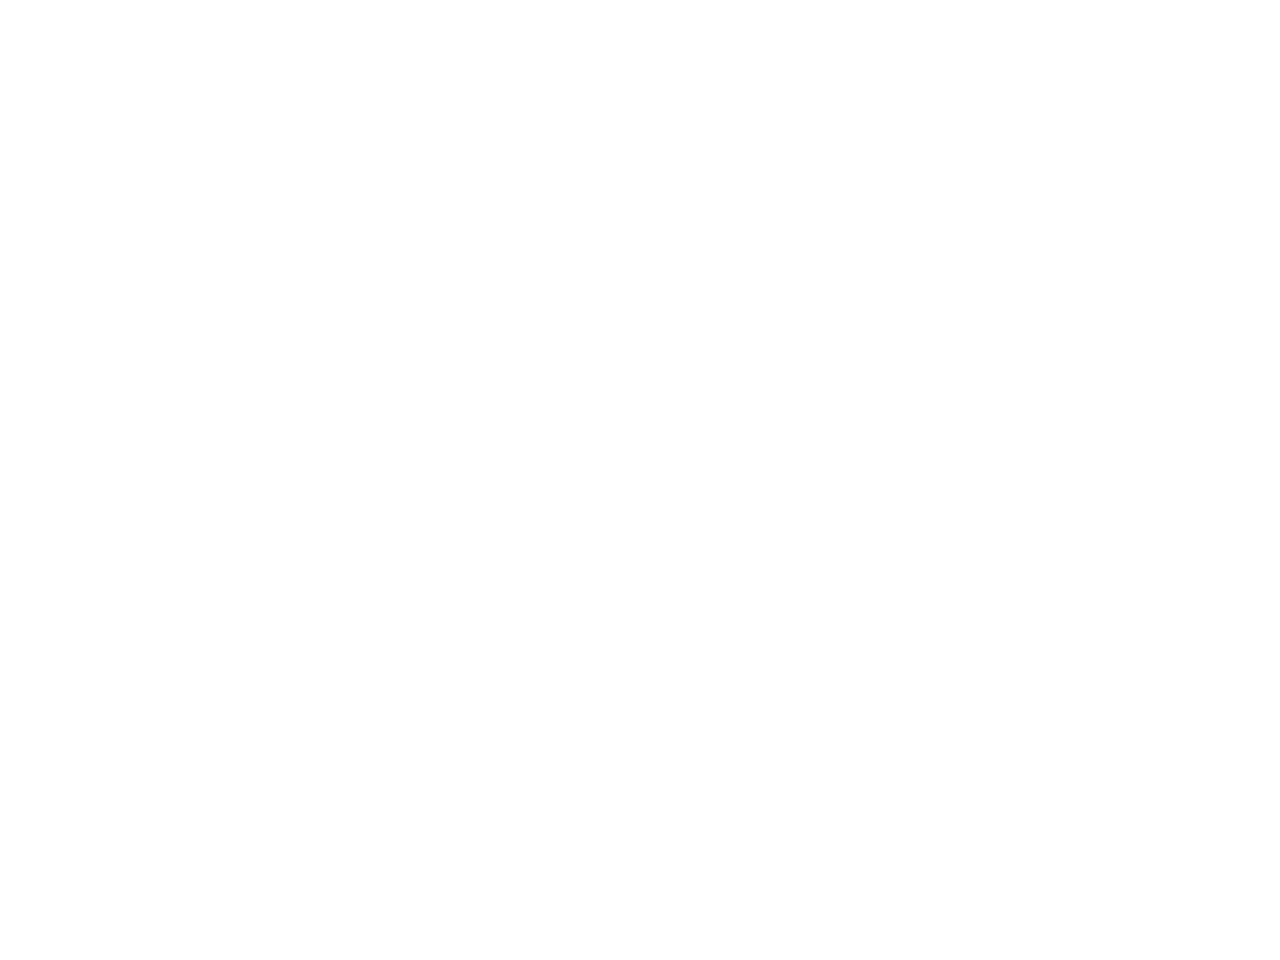

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


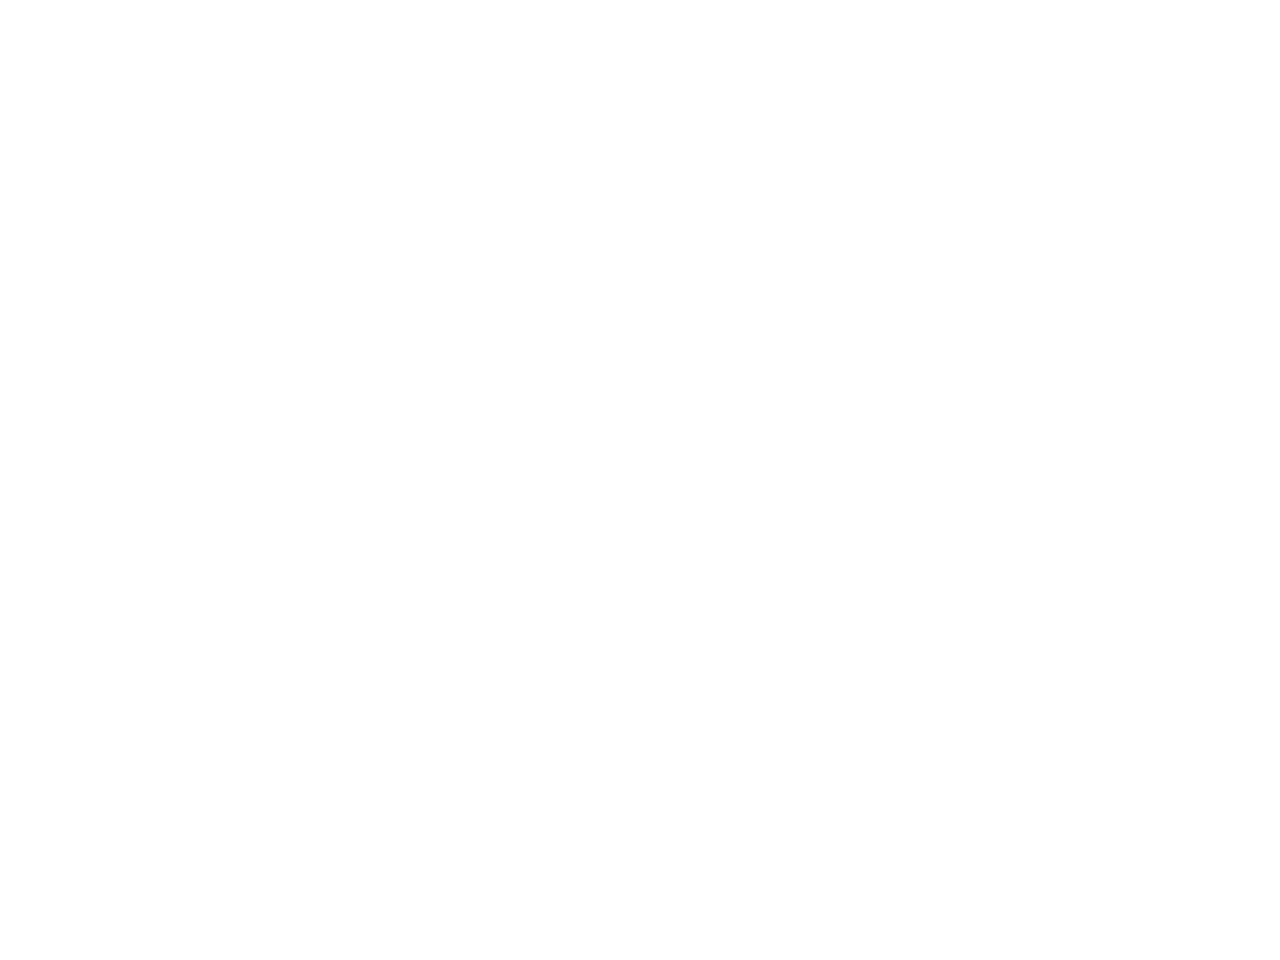

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


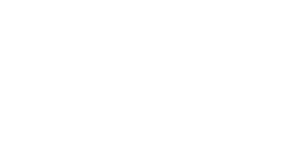

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


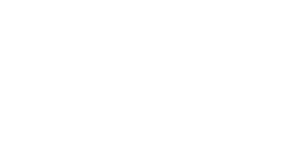

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


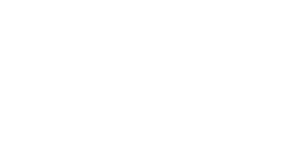

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


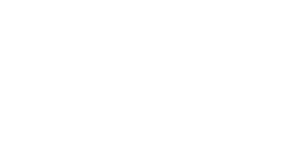

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


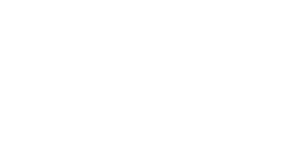

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


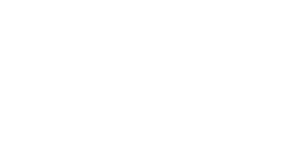

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


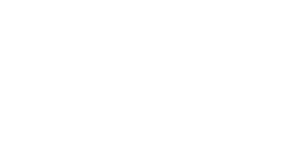

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


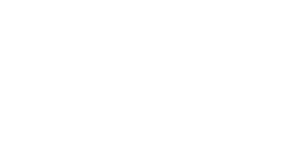

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


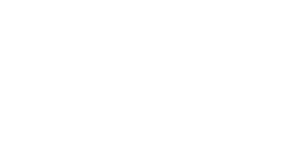

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


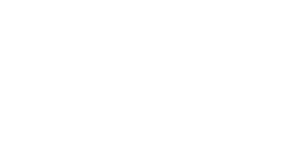

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


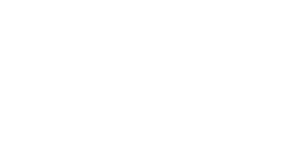

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


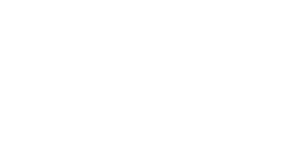

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


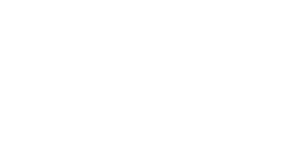

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


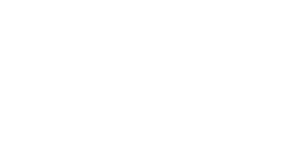

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


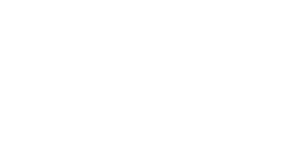

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


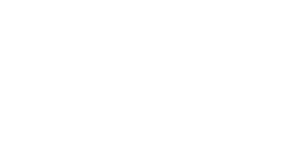

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


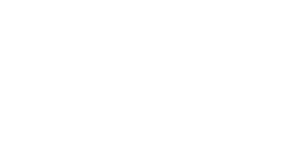

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


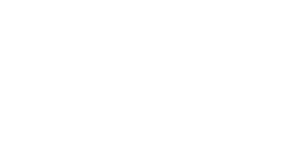

/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/anaconda/envs/adm/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


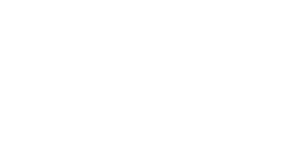

In [31]:
#Animate the quad plot over a given time period using python module imageio

filenames = []
for i in range(len(times)):
    plot_both(solveTotals(times[i], dat.T, dat.RelHum), solve_KIndex(times[i], dat.T, dat.RelHum),dat.PSL,dat.T,times[i])
    
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()

# Build mp4 video
with imageio.get_writer('StabGraphic.mp4', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)